<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/09_Milstone_Project_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2: SkimLit

In this notebook we are going to build and NLP model to make reading medical abstract easier.

source: https://arxiv.org/abs/1710.06071

##Getting the Data

We can find the source [here](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
pubmed-rct  sample_data


In [2]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
## Cheking what files are there in the PubMed_20k_RCT Dateset
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [4]:
with open('pubmed-rct/PubMed_20k_RCT/test.txt', 'r') as test_file:
  data = test_file.readlines()

len(data), len(data[0])

(35135, 12)

In [5]:
data[0]

'###24845963\n'

In [6]:
data[1]

'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'

In [7]:
## Going to start our experiments with PubMed_20k_RCT with number replaced with '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [8]:
## Getting the file directories
import os
file_names = [os.path.join(data_dir,dir) for dir in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Prepocess the Data

Write a function read in all the lines of target text file.

In [9]:
def read_lines(file_path):
  """
  Takes filepath and reads the .txt file line-by-line and returns the data in the form of list
  """
  with open(file_path, 'r') as file:
    return file.readlines()

In [10]:
train_data = read_lines(file_names[1])
train_data[: 20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [11]:
len(train_data)

210040

Make train_data into this format:

```
[{'line_number': 0,
  'target': 'Backgound',
  'text': 'the data',
  'total_lines': 10
}]
```

In [12]:
def data_dict(data_list):
  """
  This function takes list of text data and converts it into list of dictionary containing
  {'line_number': number of the line,
  'target': the category,
  'text': the actual content,
  'total_lines': total number of lines in each senction}

  The section is divided by eliminating the line containing '###' and the len(line) != 1.
  """
  data_dict = []
  for i, line in enumerate(data_list):
    if "###" not in line and len(line) != 1:
      split = line.split('\t')
      data_dict.append({'line_number': i,
                              'target': split[0],
                              'text': split[1],
                              'total_lines': len(data_list[i-1])})

  return data_dict

In [13]:
train_data_dict = data_dict(train_data)
train_data_dict[: 15]

[{'line_number': 1,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total_lines': 12},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'total_lines': 292},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'total_lines': 146},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'total_lines': 120},
 {'line_number': 5,
  'target': 'METHODS',
  'text': 'Secondary outcome measu

In [14]:
def data_dict(data_list):
  abstract_lines = ''
  abstract_samples = []

  for line in data_list:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ''

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['line_number'] = abstract_line_number
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [15]:
train_data_dict = data_dict(train_data)
train_data_dict[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [16]:
test_data = read_lines(file_names[2])
test_data_dict = data_dict(test_data)
test_data_dict[:5]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [17]:
val_data = read_lines(file_names[0])
val_data_dict = data_dict(val_data)
val_data_dict[:5]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'total_lines': 9},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'total_lines': 9},
 {'line_number': 2,
  'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'total_lines': 9},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'total_lines': 9},
 {'line_

Now that our data in the form of dictionary, let's add them into a DataFrame

In [18]:
import pandas as pd

train_data_df = pd.DataFrame(train_data_dict)
train_data_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [19]:
## Distribution of labels
train_data_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

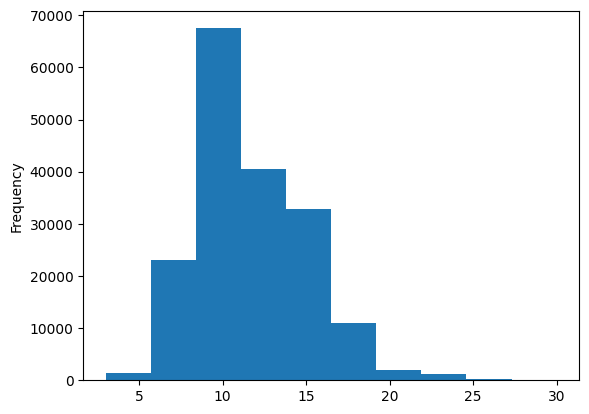

In [20]:
## Check the length of differect line
train_data_df.total_lines.plot(kind='hist')

In [21]:
test_data_df = pd.DataFrame(test_data_dict)
test_data_df.head(15)

,line_number,target,text,total_lines
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8
1,1,RESULTS,a post hoc analysis was conducted with the use...,8
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8
3,3,RESULTS,survival analyses were used to assess the asso...,8
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8
5,5,RESULTS,when mean hemodynamic profiles were compared i...,8
6,6,RESULTS,multivariable analyses revealed that patients ...,8
7,7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,8
8,8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8
9,0,BACKGROUND,minimally invasive endovascular aneurysm repai...,12


In [22]:
val_data_df = pd.DataFrame(val_data_dict)
val_data_df.head(15)

,line_number,target,text,total_lines
0,0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,9
1,1,BACKGROUND,it is not clear whether these patients would b...,9
2,2,OBJECTIVE,we sought to determine whether a @-month cours...,9
3,3,METHODS,asthmatic patients who were ige sensitized to ...,9
4,4,METHODS,primary outcomes were improvement in quality o...,9
5,5,RESULTS,sixty-five patients were randomized .,9
6,6,RESULTS,fifty-nine patients started treatment ( @ rece...,9
7,7,RESULTS,fifty-six patients took the full @ months of m...,9
8,8,RESULTS,"between the voriconazole and placebo groups , ...",9
9,9,CONCLUSIONS,we were unable to show a beneficial effect of ...,9


## Getting the lists of sentences

In [23]:
train_sentences = train_data_df.text.tolist()
test_sentences = test_data_df.text.tolist()
val_sentences = val_data_df.text.tolist()

In [24]:
len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [25]:
# First 6 sentences in trian_sentence
train_sentences[: 6]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .']

##Make Numeric labels (OneHot Encoding)

### Turning into categories

In [26]:
# train_data_df.target.unique()

In [27]:
# import numpy as np
# mapping = {
#         'OBJECTIVE': 0,
#         'METHODS': 1,
#         'RESULTS': 2,
#         'CONCLUSIONS': 3,
#         'BACKGROUND': 4
# }
# train_data_df['labels'] = np.where(train_data_df.target.isin(mapping), train_data_df.target.map(mapping), 5)

In [28]:
# train_data_df.target.unique(), train_data_df.labels.unique()

In [29]:
# train_data_df['target'].value_counts(), train_data_df.labels.value_counts()

### Label Encoding (other way)

In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data_df.target)
test_labels_encoded = label_encoder.transform(test_data_df.target)
val_labels_encoded = label_encoder.transform(val_data_df.target)

In [31]:
test_labels_encoded[:5], test_data_df.target[:5]

(array([0, 4, 4, 4, 4]),
 0    BACKGROUND
 1       RESULTS
 2       RESULTS
 3       RESULTS
 4       RESULTS
 Name: target, dtype: object)

In [32]:
## Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### OneHot Encoder

In [33]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) ## We need non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_data_df['target'].to_numpy().reshape(-1, 1))
train_data_df.target[:5], train_labels_one_hot[: 5]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0    OBJECTIVE
 1      METHODS
 2      METHODS
 3      METHODS
 4      METHODS
 Name: target, dtype: object,
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]))

In [34]:
## OneHot Encoding Testing labels
test_labels_one_hot = one_hot_encoder.transform(test_data_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [35]:
## OneHot Encoding validation labels
val_labels_one_hot = one_hot_encoder.transform(val_data_df.target.to_numpy().reshape(-1, 1))
val_labels_one_hot[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [36]:
one_hot_encoder.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

## Experimenting with different models

* 0. Naive Bayes with TF-IDF encoder (baseline)
* 1. Conv1D with token embedding
* 2. TensorFlow-Hub pretrained Feature_Extractor
* 3. Conv1D with Charecter embedding
* 4. Pretrained token embedding(same as 2) + Charecter embedding (same as 3)
* 5. Pretrained token embedding + Charecter embedding + Positional embedding

### Model_0. Naive Bayes with TF-IDF encoder

In [37]:
## Applying tfidf vectorizer to train_sentences and val_sentences with the help of Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model = Pipeline([('tfidf', TfidfVectorizer()),
                              ('mnb', MultinomialNB())])

In [38]:
## Fitting the model with train_sentences and trian_labels_encoded
naive_bayes_model.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [39]:
## Evaluating the model with validation data
naive_bayes_model.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
## Predicting on training sentences
from sklearn.metrics import accuracy_score

model_0_preds = naive_bayes_model.predict(val_sentences)

In [ ]:
## Creating a function to get metrics
def calculate_results(y_true, y_preds):
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support
  accuracy_score = accuracy_score(y_true, y_preds)
  precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_preds, average='weighted')

  return {"Accuracy": accuracy_score * 100, "precision": precision, "recall": recall, "fscore": fscore}

In [ ]:
## Calculating the results
model_0_results = calculate_results(val_labels_encoded, model_0_preds)
model_0_results

### Model_1. Conv1D with token embedding

In [ ]:
train_sentences[:5]

In [ ]:
# How long is our each sentence on average
import numpy as np
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

In [ ]:
## What the distribution looks like
import matplotlib.pyplot as plt

plt.hist(sent_len, bins=20)

In [ ]:
## How long the sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_len, 95))
output_seq_len

In [ ]:
## Maximum setence length
max(sent_len)

### Converting to numbers using textvectorization

In [170]:
import tensorflow as tf

## How many words are in our vocab (we have taken from the paper)
max_tokens = 68000
vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                               output_sequence_length=output_seq_len)

In [171]:
vectorizer.adapt(train_sentences)

In [ ]:
vectorizer(train_sentences)

In [ ]:
## How many words are there in vocabulary
vocab_len = vectorizer.vocabulary_size()
vocab_len, vectorizer.get_vocabulary()[:5]

In [ ]:
## Config of text vectorizer
vectorizer.get_config()

### Creating Embedding layer

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_len,
                                      output_dim=128,
                                      mask_zero=True)

In [ ]:
embedding(vectorizer(train_sentences[0]))

### Creating Datasets (making sure that our data loads as fast as possible)

using tensorflow data API

> Resource: https://www.tensorflow.org/guide/data_performance

In [ ]:
## Turn our data inot tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

In [ ]:
train_dataset

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

In [ ]:
## Take the TensorSliceDataset's and turn them into "prefectched" dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

In [ ]:
import tensorflow.keras.layers as layers
inputs = layers.Input(shape=(1, ), dtype='string')

x = vectorizer(inputs)

x = embedding(x)

x = layers.Conv1D(64,
                  kernel_size=3,
                  activation='relu')(x)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.summary()

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
len(train_dataset)

In [ ]:
len(train_dataset)*0.1

In [64]:
%%time
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

562/562 [==============================] - 70s 123ms/step - loss: 0.9672 - accuracy: 0.6170 - val_loss: 0.7230 - val_accuracy: 0.7224
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.6842 - accuracy: 0.7458 - val_loss: 0.6570 - val_accuracy: 0.7616
Epoch 3/3
562/562 [==============================] - 63s 112ms/step - loss: 0.6407 - accuracy: 0.7641 - val_loss: 0.6191 - val_accuracy: 0.7769
CPU times: user 4min 33s, sys: 29.8 s, total: 5min 2s
Wall time: 3min 22s


In [65]:
## Evaluating on validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6207 - accuracy: 0.7770


[0.6207172870635986, 0.7769760489463806]

In [66]:
## Predicting (our model predicts prediction probabilities for each class)
model_1_preds_probs = model_1.predict(test_dataset)
model_1_preds_probs, model_1_preds_probs.shape

942/942 [==============================] - 4s 4ms/step


(array([[2.9407033e-01, 5.6463152e-02, 2.9585251e-01, 3.2935151e-01,
         2.4262447e-02],
        [3.2650547e-03, 1.7709944e-03, 9.6797782e-01, 5.7274294e-03,
         2.1258652e-02],
        [4.2734726e-04, 1.5594235e-03, 8.6334383e-01, 2.4056721e-04,
         1.3442892e-01],
        ...,
        [2.6395894e-03, 4.0618088e-02, 5.0772384e-02, 1.6366530e-03,
         9.0433323e-01],
        [7.7694631e-03, 3.8948126e-02, 1.0341739e-01, 4.7255857e-03,
         8.4513944e-01],
        [1.0469554e-02, 3.6369655e-01, 6.0395539e-02, 1.2288152e-02,
         5.5315018e-01]], dtype=float32),
 (30135, 5))

In [67]:
# model_1_preds = [item.argmax() for item in model_1_preds_probs]
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds[: 10].numpy()

array([3, 2, 2, 2, 4, 4, 4, 0, 1, 1])

In [68]:
## Calculating results
model_1_results = calculate_results(test_labels_encoded, model_1_preds)
model_1_results

{'Accuracy': 77.42160278745645,
 'precision': 0.7701413791867716,
 'recall': 0.7742160278745644,
 'fscore': 0.7712200413776223}

In [69]:
model_0_results

{'Accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'fscore': 0.6989250353450294}

### 2. TensorFlow-Hub pretrained Feature_Extractor

model taken from here: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [70]:
import tensorflow_hub as hub
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
pretrained_embedding = hub.KerasLayer(model_url, trainable=False, name="loaded_embedding")

In [71]:
import random
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(pretrained_embedding([random_sentence]).shape)

we studied a total of @ subjects , comprising @ thalassemia patients ( mean age : @ @ years ) with a history of repeated blood transfusions , in addition to @ age - and gender-matched controls ( mean age : @ @ years ) .
(1, 512)


In [72]:
inputs = layers.Input([], dtype='string')

x = pretrained_embedding(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [73]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 loaded_embedding (KerasLay  (None, 512)               256797824 
 er)                                                             
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [74]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [75]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1 * len(train_dataset)),
                        epochs=3,
                        validation_data=val_dataset,
                        validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9175 - accuracy: 0.6487 - val_loss: 0.7952 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7680 - accuracy: 0.7018 - val_loss: 0.7542 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7514 - accuracy: 0.7115 - val_loss: 0.7374 - val_accuracy: 0.7121


In [76]:
model_2_preds_probs = model_2.predict(val_dataset)
model_2_preds_probs

945/945 [==============================] - 17s 18ms/step


array([[0.42486334, 0.37298858, 0.00331514, 0.1899722 , 0.00886072],
       [0.34137034, 0.49514467, 0.00441218, 0.15561628, 0.00345657],
       [0.21647586, 0.159579  , 0.02216803, 0.55523306, 0.0465441 ],
       ...,
       [0.00193308, 0.00683263, 0.0540955 , 0.00108487, 0.9360539 ],
       [0.00434158, 0.04833648, 0.2006688 , 0.00189673, 0.74475646],
       [0.17664167, 0.30812734, 0.4446759 , 0.00650793, 0.06404711]],
      dtype=float32)

In [77]:
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [78]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'Accuracy': 71.40540182708858,
 'precision': 0.7143223886312235,
 'recall': 0.7140540182708858,
 'fscore': 0.7111493404766372}

In [79]:
model_1_results

{'Accuracy': 77.42160278745645,
 'precision': 0.7701413791867716,
 'recall': 0.7742160278745644,
 'fscore': 0.7712200413776223}

### Model_3. Conv1D with Charecter embedding

>Previously we created token-level embedding but we need to do similar steps for character-level embedding.


#### Creating Character level Tokenizer

In [80]:
train_sentences[:3]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

In [81]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [82]:
## Make function to split sentences into characters

def sent_char(data_list):
  return " ".join(list(data_list))

In [83]:
train_chars = [sent_char(item)for item in train_sentences]
val_chars = [sent_char(item)for item in val_sentences]
test_chars = [sent_char(item)for item in test_sentences]

In [84]:
test_chars[1]

'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .'

In [85]:
## Average character length

char_len = [len(item) for item in train_sentences]
avg_char_len = np.mean(char_len)

In [86]:
avg_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

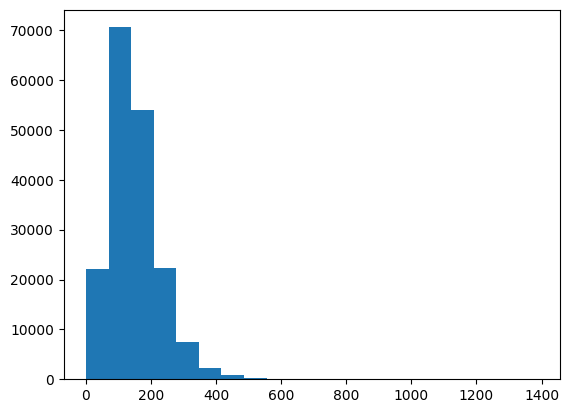

In [87]:
## Check the distribusion of the chars length

plt.hist(char_len, bins=20)

In [88]:
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [89]:
## Get the keyboard characters
import string
alphabets = string.ascii_lowercase + string.digits + string.punctuation
alphabets

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [168]:
## Create char-level token vectorizer instance
num_char_tokens = len(alphabets) + 2 ## Adding 2 because, the 'alphabets' does not contains space and voo ([UNK])

char_vectorizer = layers.TextVectorization(max_tokens=num_char_tokens,
                                           output_sequence_length = output_seq_char_len)

In [169]:
## Adapt char_vectorizer to training characters

char_vectorizer.adapt(train_chars)

In [92]:
## Getting char_vectorizer vocab stats

char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [93]:
random_chars = random.choice(train_chars)
char_vectorizer([random_chars])

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[22, 12,  7,  7, 10,  9,  5, 15, 14, 12,  2,  9, 20,  2,  8,  2,
        11,  7, 12, 12,  2, 11,  3,  2, 10, 14,  8,  4,  7,  8,  3,  7,
         3,  8,  2,  5,  3, 15,  2,  6,  3,  5,  6, 10,  7,  6, 14,  7,
         9,  3,  3,  8,  2,  5,  3, 15,  2,  6,  3, 10,  5, 19,  9,  5,
         6, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

#### Creating the model

In [94]:
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                           output_dim=25,
                                           mask_zero=True)

In [95]:
char_embedding(char_vectorizer(random_chars))

<tf.Tensor: shape=(290, 25), dtype=float32, numpy=
array([[-0.02685677, -0.02340393,  0.0106272 , ...,  0.00607383,
        -0.02657756,  0.03507567],
       [-0.04270699, -0.01258397, -0.03823913, ..., -0.02273365,
        -0.00698408,  0.00374072],
       [ 0.02843602,  0.03070014,  0.00546   , ..., -0.04119726,
         0.02084382, -0.01536221],
       ...,
       [ 0.02227999,  0.02170197, -0.02986602, ..., -0.0488507 ,
         0.0431799 , -0.04799194],
       [ 0.02227999,  0.02170197, -0.02986602, ..., -0.0488507 ,
         0.0431799 , -0.04799194],
       [ 0.02227999,  0.02170197, -0.02986602, ..., -0.0488507 ,
         0.0431799 , -0.04799194]], dtype=float32)>

In [96]:
np.array(train_chars).shape

(180040,)

In [97]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))

In [98]:
train_char_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [99]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [100]:
test_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [101]:
inputs = layers.Input(shape=(1, ), dtype='string')

x = char_vectorizer(inputs)

x = char_embedding(x)

x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)

x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(len(class_names), activation='softmax', name="ouput_layer")(x)

model_3 = tf.keras.Model(inputs, outputs)

In [102]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 ouput_layer (Dense)         (None, 5)                 325 

In [103]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [104]:
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1 * len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 42ms/step - loss: 1.2578 - accuracy: 0.4854 - val_loss: 1.0492 - val_accuracy: 0.5874
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 1.0120 - accuracy: 0.5929 - val_loss: 0.9476 - val_accuracy: 0.6313
Epoch 3/3
562/562 [==============================] - 21s 38ms/step - loss: 0.9242 - accuracy: 0.6385 - val_loss: 0.8701 - val_accuracy: 0.6686


In [105]:
model_3_evalate = model_3.evaluate(val_char_dataset)
model_3_evalate

945/945 [==============================] - 12s 13ms/step - loss: 0.8850 - accuracy: 0.6554


[0.8849853873252869, 0.6554018259048462]

In [106]:
model_3_preds_probs = model_3.predict(val_chars)
model_3_preds_probs

945/945 [==============================] - 6s 6ms/step


array([[0.1374199 , 0.3416409 , 0.20601612, 0.23170118, 0.08322181],
       [0.27601892, 0.35343382, 0.02698976, 0.2924118 , 0.0511458 ],
       [0.09683637, 0.16153191, 0.1191434 , 0.57607806, 0.04641025],
       ...,
       [0.01491278, 0.03425604, 0.08600794, 0.01041424, 0.854409  ],
       [0.02581797, 0.15071861, 0.2340187 , 0.07368293, 0.51576173],
       [0.4346991 , 0.3635964 , 0.13657285, 0.04986276, 0.01526891]],
      dtype=float32)

In [107]:
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 3, 2, 2])>

In [108]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'Accuracy': 65.54018270885742,
 'precision': 0.6446534001704882,
 'recall': 0.6554018270885741,
 'fscore': 0.6452513140666071}

### Model_4: Pretrained token embedding(same as 2) + Charecter embedding (same as 3)

In [109]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

In [110]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

In [111]:
train_token_char_dataset

<_ZipDataset element_spec=((TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None)), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [112]:
## batching and prefetch
train_token_char_dataset_batched = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset_batched = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
train_token_char_dataset_batched

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [114]:
## token input model
inputs = layers.Input([], dtype='string')

token_embedding = pretrained_embedding(inputs)
token_output = layers.Dense(128, activation='relu', name='token_output_layer')(token_embedding)
token_model = tf.keras.Model(inputs, token_output, name='token_model')

## char input model
char_inputs = layers.Input(shape=(1, ), dtype='string')
char_vec = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vec)

char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embed)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

## Concatenate token and char inputs
token_char_concatenate = layers.Concatenate()([token_model.output, char_model.output])

## Create Output layers
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)

## Constact model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

In [115]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['input_5[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 loaded_embedding (KerasLay  (None, 512)                  2567978   ['input_4[0][0]']       

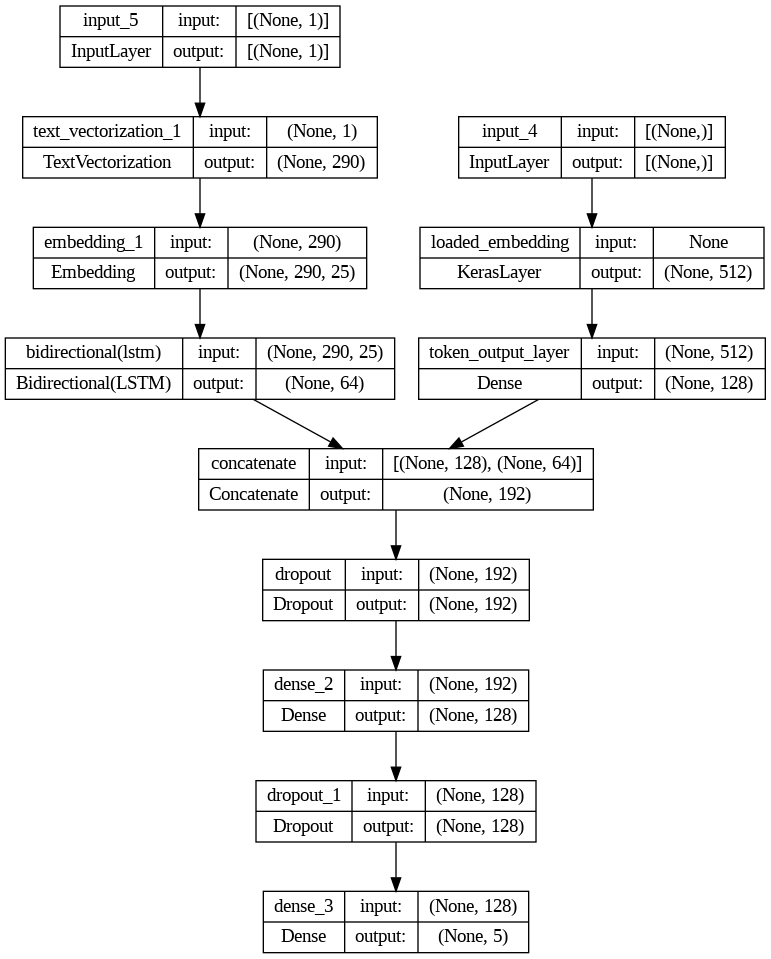

In [116]:
## Ploting the model_4
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [117]:
## Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#### Data Pipeline (tf.data.dataset)

In [118]:
history_4 = model_4.fit(train_token_char_dataset_batched,
                      steps_per_epoch=int(0.1 * len(train_token_char_dataset_batched)),
                      epochs=3,
                      validation_data=val_token_char_dataset_batched,
                      validation_steps=int(0.1 * len(val_token_char_dataset_batched)))

Epoch 1/3
562/562 [==============================] - 213s 359ms/step - loss: 0.9801 - accuracy: 0.6074 - val_loss: 0.7778 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 189s 336ms/step - loss: 0.7982 - accuracy: 0.6949 - val_loss: 0.7145 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 190s 339ms/step - loss: 0.7746 - accuracy: 0.7017 - val_loss: 0.6904 - val_accuracy: 0.7447


In [119]:
# val_token_char_data_inputs, val_token_char_data_labels = val_token_char_dataset.unzip()

model_4_preds_probs = model_4.predict(val_token_char_dataset_batched)
model_4_preds_probs[:5]

945/945 [==============================] - 71s 72ms/step


array([[0.41657504, 0.3313173 , 0.0060898 , 0.23810233, 0.00791548],
       [0.3697471 , 0.39159536, 0.00589538, 0.22999726, 0.00276487],
       [0.2981119 , 0.15222928, 0.05760365, 0.4535255 , 0.03852962],
       [0.01110853, 0.01772896, 0.85683364, 0.00556127, 0.10876753],
       [0.02801386, 0.05916478, 0.6437334 , 0.01445314, 0.25463483]],
      dtype=float32)

In [120]:
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [121]:
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'Accuracy': 73.58996425261486,
 'precision': 0.7371042936080202,
 'recall': 0.7358996425261486,
 'fscore': 0.7331928772884394}

###Model_5. Pretrained token embedding + Charecter embedding + Positional embedding

In [123]:
train_data_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


>🔑Note: any Engineered features used to train model need to be available at test time. In our case, the line numbers and total lines are available.

#### Create Feature embedding

<Axes: ylabel='Frequency'>

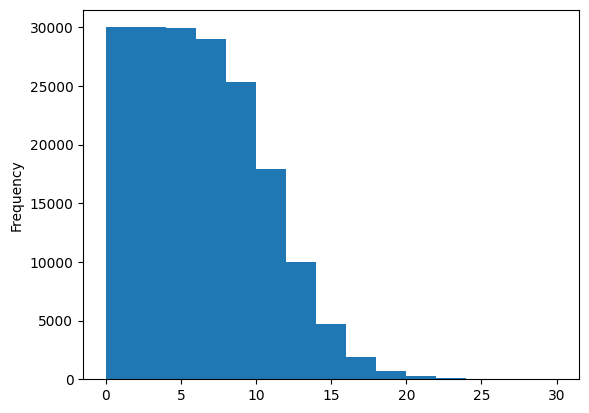

In [160]:
## The distribution of 'line_number'
train_data_df.line_number.plot.hist(bins=15)

In [161]:
## Use TensorFlow to create one-hot-encoded tensors of our 'line_number' column
train_line_number_one_hot = tf.one_hot(train_data_df.line_number.to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_data_df.line_number.to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_data_df.line_number.to_numpy(), depth=15)
train_line_number_one_hot[:5], train_data_df.line_number[:5]

(<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 0    0
 1    1
 2    2
 3    3
 4    4
 Name: line_number, dtype: int64)

<Axes: ylabel='Frequency'>

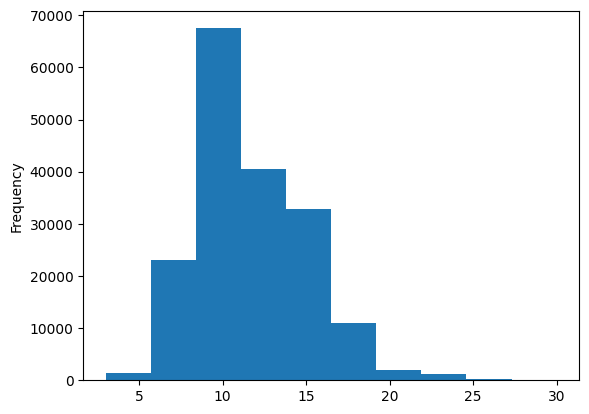

In [162]:
## checking the distribution of total_lines column
train_data_df.total_lines.plot.hist()

In [163]:
np.percentile(train_data_df.total_lines, 98)

20.0

In [164]:
## One hot encoding the column 'total_lines'
train_total_lines_one_hot = tf.one_hot(train_data_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_data_df.total_lines.to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_data_df.total_lines.to_numpy(), depth=20)
train_total_lines_one_hot[:5]

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

#### Building tribrid embedding model

1. Create token-level model
2. Create char-level model
3. Create model for 'line_number' features
4. Create model for 'total_lines' features
5. Combine the output of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the output of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create the output layer to accept the tribrid embedding and output label probabilities
8. Conbine the inputs of 1, 2, 3, 4 and output of into a tf.keras.Model

In [207]:
## 1.Token Inputs
token_inputs = layers.Input([], dtype='string')
token_embed = pretrained_embedding(token_inputs)
token_outputs = layers.Dense(128, activation='relu', name="token_output_layer")(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_level_model")

## 2.Char Inputs
char_inputs = layers.Input(shape=(1, ), dtype='string')
char_vec = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vec)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

## 3.Create model for "line_number" features model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32)
line_number_dense = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_dense, name="line_number_model")

## 4.Create model for "total_lines" features model
total_line_inputs = layers.Input(shape=(20, ), dtype=tf.float32)
total_line_dense = layers.Dense(64, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_dense, name="total_line_model")

## 5.Combine the output of 1 & 2 using tf.keras.layers.Cocatenate
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output, char_model.output])

x = layers.Dense(256, activation='relu')(combined_embeddings)
x = layers.Dropout(0.5)(x)

## 6. Combine positional embedding with combined token embedding
tribrid_embedding = layers.Concatenate(name="char_token_tribrid_embedding")([line_number_model.output,
                                                                             total_line_model.output,
                                                                             x])

## 7. Create an output layer to accept the tribrid embedding and output label probability
output_layer = layers.Dense(5, activation='relu', name="output_layer")(tribrid_embedding)

## 8. Putting togather all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [208]:
# train_line_number_one_hot[0].shape

In [209]:
# train_total_lines_one_hot[0].shape

In [210]:
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_2 (Text  (None, 290)                  0         ['input_33[0][0]']            
 Vectorization)                                                                                   
                                                                                                  
 loaded_embedding (KerasLay  (None, 512)                  2567978   ['input_32[0][0]']     

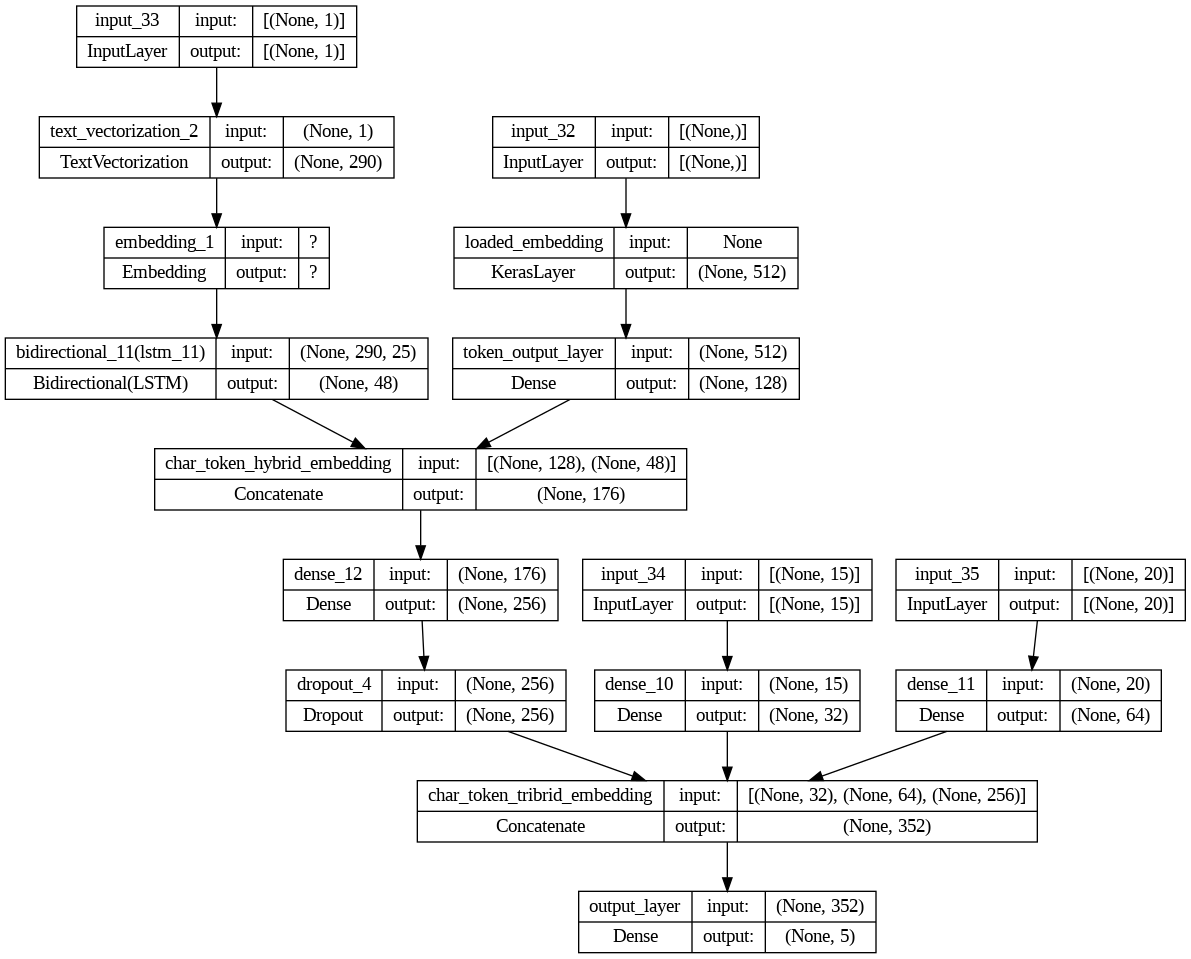

In [211]:
plot_model(model_5, show_shapes=True)

>what is label_smoothing?

Label smoothing is a regularization technique in deep learning that's used in a model's loss function to prevent overfitting and make a model less confident about a single class.

really confidence: `[0.0, 0.0, 1.0, 0.0, 0.0]`
after smootheninig: maybe like `[0.01, 0.01, 0.96, 0.01, 0.01]`

In [212]:
## Compiling token, char and positional embedding layer
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), ## Helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

####Create tribrid embedding dataset using tf.data

In [213]:
## Create training validation dataset (with all kind of inputs)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                           train_total_lines_one_hot,
                                                           train_sentences,
                                                           train_chars))

train_char_token_pos_label = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_label))

train_char_token_pos_dataset_batched = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



## For validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                        val_total_lines_one_hot,
                                                        val_sentences,
                                                        val_chars))

val_char_token_pos_label = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_label))

val_char_token_pos_dataset_batched = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [214]:
## Check the input shape
train_char_token_pos_dataset_batched

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [215]:
## Fitting the model
history_5 = model_5.fit(train_char_token_pos_dataset_batched,
                        steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset_batched)),
                        epochs=3,
                        validation_data=val_char_token_pos_dataset_batched,
                        validation_steps=int(0.1 * len(val_char_token_pos_dataset_batched)))

Epoch 1/3
562/562 [==============================] - 313s 542ms/step - loss: 1.4341 - accuracy: 0.5787 - val_loss: 1.2825 - val_accuracy: 0.6456
Epoch 2/3
562/562 [==============================] - 196s 348ms/step - loss: 1.2555 - accuracy: 0.6630 - val_loss: 1.1741 - val_accuracy: 0.6955
Epoch 3/3
562/562 [==============================] - 182s 323ms/step - loss: 1.2000 - accuracy: 0.6837 - val_loss: 1.1239 - val_accuracy: 0.7400


In [216]:
model_5.evaluate(val_char_token_pos_dataset_batched)

945/945 [==============================] - 72s 76ms/step - loss: 1.1179 - accuracy: 0.7423


[1.117857575416565, 0.742287814617157]

In [217]:
model_5_preds_probs = model_5.predict(val_char_token_pos_dataset_batched)
model_5_preds_probs[:6]

945/945 [==============================] - 67s 67ms/step


array([[1.1614785 , 0.46246296, 0.08611993, 0.93884355, 0.26349783],
       [0.8081628 , 0.589329  , 0.44527176, 0.6972346 , 0.22167915],
       [0.7208547 , 0.5581727 , 0.6013109 , 0.82280797, 0.44190544],
       [0.32527873, 0.41582093, 2.3500676 , 0.41745836, 0.53112537],
       [0.28622702, 0.42578262, 1.1584008 , 0.32741028, 1.2752111 ],
       [0.28152946, 0.43282843, 3.4346962 , 0.42964792, 1.6991099 ]],
      dtype=float32)

In [218]:
model_5_preds = tf.argmax(model_5_preds_probs, axis=1)
model_5_preds[:6]

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2])>

In [219]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'Accuracy': 74.22878326492784,
 'precision': 0.746404002857739,
 'recall': 0.7422878326492784,
 'fscore': 0.7338996815597757}

In [220]:
model_4_results

{'Accuracy': 73.58996425261486,
 'precision': 0.7371042936080202,
 'recall': 0.7358996425261486,
 'fscore': 0.7331928772884394}